<a href="https://colab.research.google.com/github/enakai00/colab_GenAI_lecture/blob/main/14_Diffusion_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, random
os.environ['PYTHONHASHSEED'] = str(20230629)
random.seed(20230629)

import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import layers, models, losses
from sklearn import datasets

np.random.seed(20230629)
tf.random.set_seed(20230629)

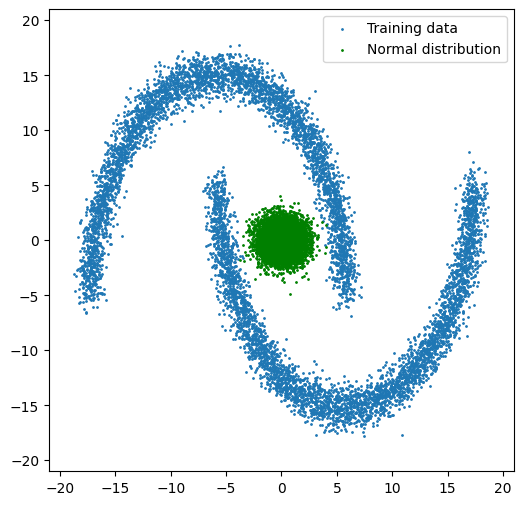

In [2]:
data = datasets.make_moons(8000, noise=0.05)[0].astype("float32")
norm = layers.Normalization()
norm.adapt(data)
train_data = norm(data) * 10

normal_samples = np.random.multivariate_normal([0, 0], [[1, 0], [0, 1]],
                                               size=8000)

fig = plt.figure(figsize=(6, 6))
subplot = fig.add_subplot(1, 1, 1)
subplot.set_xlim((-21, 21))
subplot.set_ylim((-21, 21))
subplot.scatter(train_data[:, 0], train_data[:, 1], s=1,
                label='Training data')
subplot.scatter(normal_samples[:, 0], normal_samples[:, 1], color='green', s=1,
                label='Normal distribution')
_ = subplot.legend()

In [3]:
def diffusion_schedule(diffusion_times):
    # offset cosine schedule
    min_signal_rate = 0.02
    max_signal_rate = 0.95
    start_angle = tf.acos(max_signal_rate)
    end_angle = tf.acos(min_signal_rate)
    diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)
    signal_rates = tf.cos(diffusion_angles)
    noise_rates = tf.sin(diffusion_angles)

    return noise_rates, signal_rates

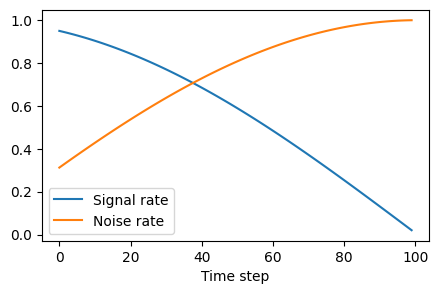

In [4]:
times = np.linspace(0, 1, 100)
df = DataFrame({'Signal rate': diffusion_schedule(times)[1],
                'Noise rate': diffusion_schedule(times)[0]})
df.index.name = 'Time step'
_ = df.plot(figsize=(5, 3))

In [19]:
import matplotlib.animation as animation
from IPython.display import Image

def show_data(subplot, data):
    subplot.set_xlim((-21, 21))
    subplot.set_ylim((-21, 21))
    subplot.set_aspect('equal')
    a = subplot.scatter(data[:, 0], data[:, 1], color='#1f77b4', s=1)
    return [a]

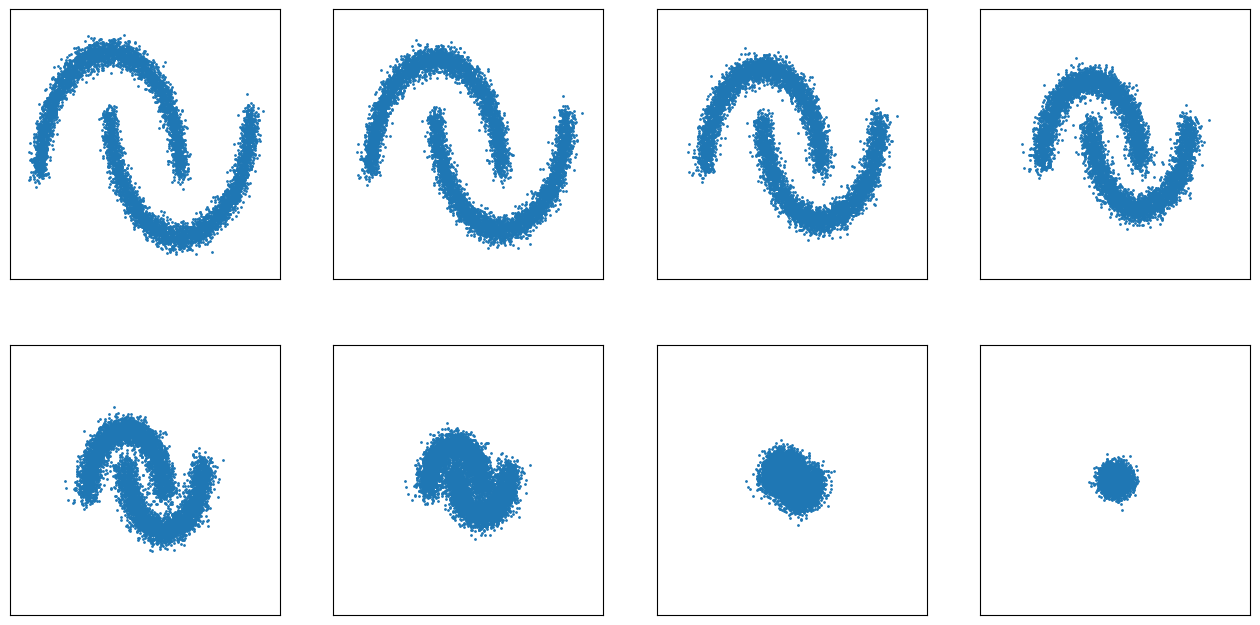

In [31]:
noise_data = np.random.multivariate_normal([0, 0], [[1, 0], [0, 1]],
                                           size=len(train_data))

fig = plt.figure(figsize=(16, 8))
for c, t in enumerate(np.linspace(0, 1, 8)):
    subplot = fig.add_subplot(2, 4, c+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    noise_rate, signal_rate = diffusion_schedule(t)
    diffused_data = signal_rate * train_data + noise_rate * noise_data
    show_data(subplot, diffused_data)

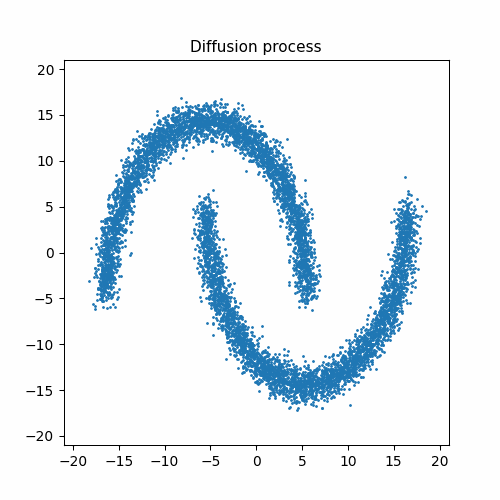

In [21]:
fig = plt.figure(figsize=(5, 5))
subplot = fig.add_subplot(1, 1, 1)
subplot.set_title('Diffusion process', fontsize=11)
frames = []
for c, t in enumerate(np.linspace(0, 1, 20)):
    noise_rate, signal_rate = diffusion_schedule(t)
    diffused_data = signal_rate * train_data + noise_rate * noise_data
    frames.append(show_data(subplot, diffused_data))

ani = animation.ArtistAnimation(fig, frames, interval=80)
ani.save('diffusion_process.gif', writer='pillow')
plt.close()

Image('diffusion_process.gif')

In [6]:
diffusion_model = models.Sequential(name='diffusion_model')
diffusion_model.add(layers.Dense(64, input_shape=(3,)))
diffusion_model.add(layers.Dense(64, activation='relu'))
diffusion_model.add(layers.Dense(64, activation='relu'))
diffusion_model.add(layers.Dense(64, activation='relu'))
diffusion_model.add(layers.Dense(64, activation='relu'))
diffusion_model.add(layers.Dense(2, name='estimated_noise_data'))

diffusion_model.summary()

Model: "diffusion_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                256       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 estimated_noise_data (Dense  (None, 2)                130       
 )                                                               
                                                   

In [7]:
diffusion_model.compile(optimizer='adam', loss='mse')

In [8]:
%%time
num_examples = len(train_data)
for c in range(25):
    print('Iteration: {}'.format(c+1), end='', flush=True)
    train_noisy_data = np.array([])
    label_data = np.array([])

    noise_data = np.random.multivariate_normal([0, 0], [[1, 0], [0, 1]],
                                               size=num_examples)

    for _ in range(10):
        t = np.random.uniform(0, 1, size=1)
        noise_rate, signal_rate = diffusion_schedule(t)
        noisy_data = signal_rate * train_data + noise_rate * noise_data
        noise_rate_stack = np.array([noise_rate]*num_examples).reshape(num_examples, 1)
        noisy_data = np.hstack((noisy_data, noise_rate_stack))

        if len(train_noisy_data) > 0:
            train_noisy_data = np.vstack((train_noisy_data, noisy_data))
        else:
            train_noisy_data = noisy_data

        if len(label_data) > 0:
            label_data = np.vstack((label_data, noise_data))
        else:
            label_data = noise_data

    history = diffusion_model.fit(train_noisy_data, label_data, batch_size=2000,
                                  epochs=20, verbose=0)
    loss = history.history['loss'][-1]
    print(' - loss: {:0.4f}'.format(loss), flush=True)

Iteration: 1 - loss: 0.7556
Iteration: 2 - loss: 0.6285
Iteration: 3 - loss: 0.6220
Iteration: 4 - loss: 0.5927
Iteration: 5 - loss: 0.6647
Iteration: 6 - loss: 0.6177
Iteration: 7 - loss: 0.6522
Iteration: 8 - loss: 0.6601
Iteration: 9 - loss: 0.6584
Iteration: 10 - loss: 0.6249
Iteration: 11 - loss: 0.7231
Iteration: 12 - loss: 0.6663
Iteration: 13 - loss: 0.7034
Iteration: 14 - loss: 0.6438
Iteration: 15 - loss: 0.6093
Iteration: 16 - loss: 0.5742
Iteration: 17 - loss: 0.6305
Iteration: 18 - loss: 0.6724
Iteration: 19 - loss: 0.6530
Iteration: 20 - loss: 0.6771
Iteration: 21 - loss: 0.6696
Iteration: 22 - loss: 0.5709
Iteration: 23 - loss: 0.6209
Iteration: 24 - loss: 0.7072
Iteration: 25 - loss: 0.6276
CPU times: user 5min 32s, sys: 10.2 s, total: 5min 42s
Wall time: 4min 14s


In [9]:
def reverse_diffusion(initial_data, steps=100):
    denoise_history = [initial_data]
    num_examples = len(initial_data)
    step_size = 1 / steps
    current_data = initial_data
    for step in range(steps):
        t = 1 - step * step_size
        noise_rate, signal_rate = diffusion_schedule(t)
        train_input = np.hstack((current_data, np.array([noise_rate]*num_examples).reshape(num_examples, 1)))
        estimated_noise = diffusion_model.predict(train_input, verbose=0)
        estimated_data = (current_data - noise_rate * estimated_noise) / signal_rate
        next_noise_rate, next_signal_rate = diffusion_schedule(t-step_size)
        current_data = next_signal_rate * estimated_data + next_noise_rate * estimated_noise
        denoise_history.append(current_data)

    return denoise_history

In [10]:
noise_data = np.random.multivariate_normal([0, 0], [[1, 0], [0, 1]], size=4000)
denoise_history = reverse_diffusion(noise_data, steps=100)

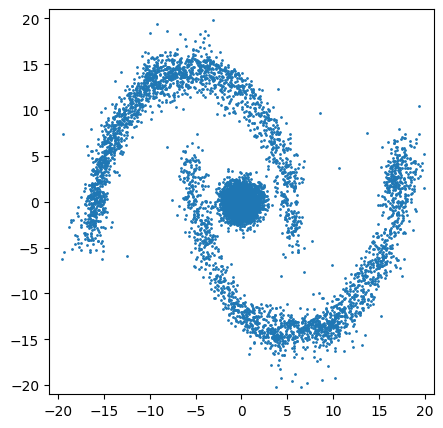

In [13]:
fig = plt.figure(figsize=(5, 5))
subplot = fig.add_subplot(1, 1, 1)
_ = show_data(subplot, denoise_history[0])
_ = show_data(subplot, denoise_history[-1])

In [26]:
np.linspace(0, len(denoise_history), 8).astype('int')


array([  0,  14,  28,  43,  57,  72,  86, 101])

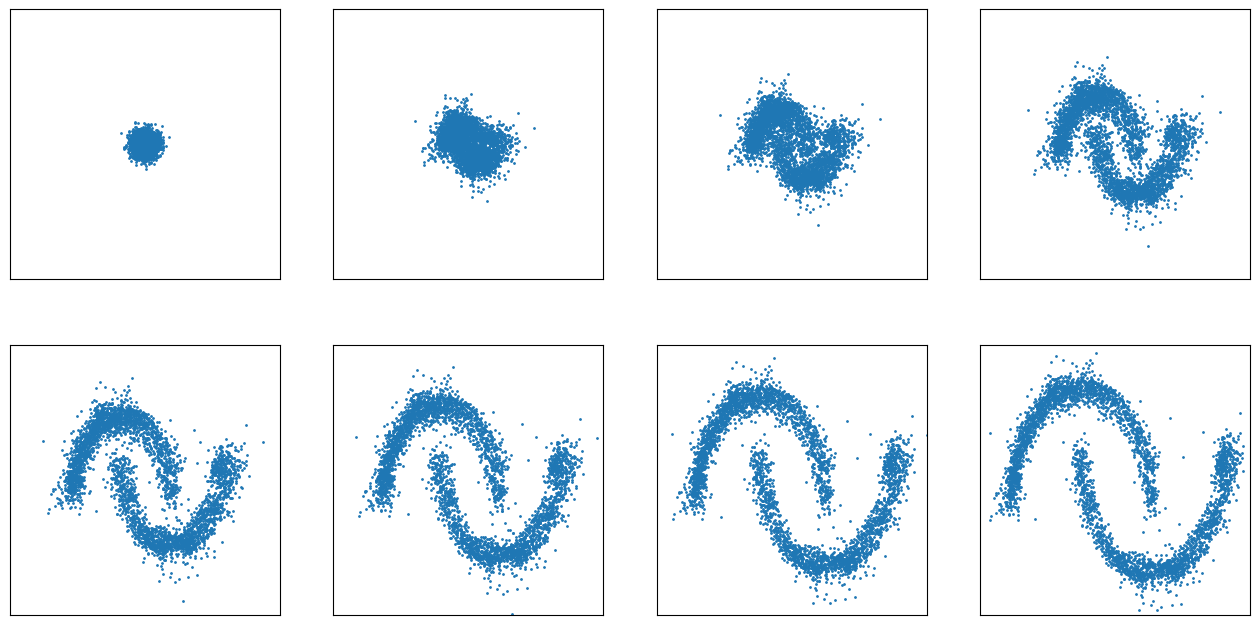

In [30]:
fig = plt.figure(figsize=(16, 8))
for c, i in enumerate(np.linspace(0, len(denoise_history)-1, 8)):
    subplot = fig.add_subplot(2, 4, c+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    show_data(subplot, denoise_history[int(i)])

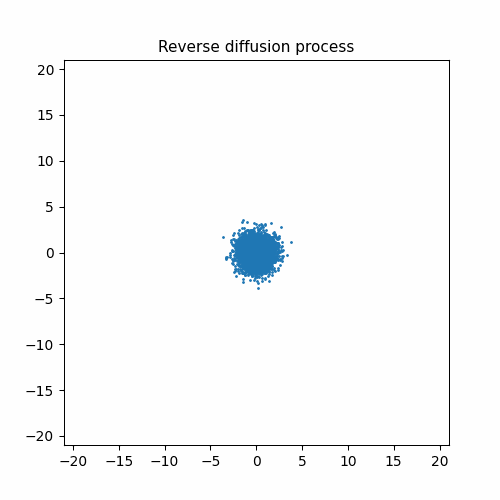

In [25]:
fig = plt.figure(figsize=(5, 5))
subplot = fig.add_subplot(1, 1, 1)
subplot.set_title('Reverse diffusion process', fontsize=11)
frames = []
for c in range(0, len(denoise_history), 4):
    frames.append(show_data(subplot, denoise_history[c]))

ani = animation.ArtistAnimation(fig, frames, interval=80)
ani.save('reverse_diffusion_process.gif', writer='pillow')
plt.close()

Image('reverse_diffusion_process.gif')